### Golden search in one dimension

Suppose we have a complicated function that depends on quite a few variables. Given observational data, and the forward model, we want to estimate the best value for one of the variables. This optimization problem is a good candidate for the golden search algorithm.

#### Forward model - magnetic dipole
In this example, we want to model the depth to a buried magnetic body based on the shape and amplitude of the magnetic observations observed along a profile across the top of the body. Use the solution based on a magnetic dipole. That is, the equation for a magnetic dipole is our forward model. The expected magnetic anomaly across the dipole depends on a lot of variables:

$$m = f(x,y,z,a, M_I, M_D, M_i, E_I, E_D) $$

$m$ is the magnetic anomaly at any point ($x,y$), $z$ is the depth of the dipole, $a$ is the equivalent volume, related to the magnetic dipole. The vector of magnetization is expressed as $M_I$, $M_D$, and $M_i$: inclination, declination, and intensity, respectively. $E_I$ and $E_D$ are the inclination and declination of the Earth's magnetic field at the location of the dipole.

The method of calculating the magnetic anomaly due to a dipole is provided in the function "magnetized_sphere" in the following.

#### Cost Function - sum of the squared errors
We want to compare the observed magnetic values and the calculated anomaly using the magnetized_sphere function. There are lots of ways to compare the observed data and the calculated data. Here, we are going to use the sum of the squared errors (SSE). Sometimes this is referred to as the cost function. Our goal is to minimize the value of the cost function -- minimize the sum of the squared errors as a measure of the difference between the observed and the calculated magnetic anomalies.

#### Golden search
Golden search is an algorithm for estimating the value of one parameter (one dimension) in a complicated (but not too complicated!) equation. 

Let's say we want to estimate the depth of the magnetic dipole, given all the other parameters and given observed, but noisy, magnatic values along a profile line across the magnetized body. One approach would be to guess values of the depth, solve for the magnetic anomaly, and calculate the SSE. The "best" depth, according to our cost function, is the depth that corresponds to the smallest SSE. One could plot a graph of SSE as a function of depth and identify the minimum SSE, and hence the best value of depth.

The golden search simply automates this search process. These are the main steps in the golden search algorithm

1. Estimate the SSE at three initial guesses of the depth, these are the "bracketing points"
2. Identify which of the three solutions is the worst (has the largest SSE)
3. Move the worst solution toward the best solution. Keep the best solution in the middle, between the other two points; move the worst point (change the guess of the value of the depth in this case) approximately 2/3s of the way between the other two points (actually the golden ratio  is 0.61803). The main feature of the golden search is how this selection of a new depth value (the movement of the worst solution) takes place most efficiently.
4. Continue selecting new values, always by movong the worst soluton, until the three points bracketing the solution are very close to each other (they all agree on the depth within a reasonable tolerance).

The following code implements a workflow to solve this problem using artifical, but noisy data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [2]:

# Calculate the magnetic anomaly due to a buried magnetized sphere
def magnetized_sphere(x, y, z, a, minc, mdec, mi, einc, edec):
    
    #sphere is centered at point (0,0,z)
    #set depth of center > 0, z in m
    #set the radius, a < $z

    #set magnetization minc (amp/m)
    minc = minc*np.pi/180 #inclination down in rad
    mdec = mdec*np.pi/180  #declination east in rad
    # mi is intensity of magnetization (amp/m)

    #calculate direction cosines for magnetiation
    ml = np.cos(minc) * np.cos(mdec)
    mm = np.cos(minc) * np.sin(mdec)
    mn = np.sin(minc)

    #calculate the dipole moment assuming a sphere shape
    #notice this scales linearly with the
    #intensity of magnetization
    dpm = 4/3 * np.pi * a**3 * mi

    #components of magnetization in x,y,z directions
    mx = mi * ml
    my = mi * mm
    mz = mi * mn

    #set earth's field
    einc = einc*np.pi/180  #inclination down in rad
    edec = edec*np.pi/180   #declination east in rad

    el = np.cos(einc) * np.cos(edec)
    em = np.cos(einc) * np.sin(edec)
    en = np.sin(einc); 

    #proportionality constant is
    # magnetic permeability * 1e9 
    #to convert of nT
    prop = 400*np.pi;

    

    #px is the northing of the observation point
    #py is the easting of the observation point
 
    z = -z

    r2 = x**2 + y**2 + z**2
    r = np.sqrt(r2)
    r5 = r**5
    dotprod = x*mx + y*my + z*mz

    #components of the anomalous magnetic field
    bx = prop*dpm*(3*dotprod*x-r2*mx)/r5
    by = prop*dpm*(3*dotprod*y-r2*my)/r5
    bz = prop*dpm*(3*dotprod*z-r2*mz)/r5

    #calculate total anomaly
    #this calculation works for anomaly << total field strength
    b_total = el*bx + em*by + en*bz;

    return b_total


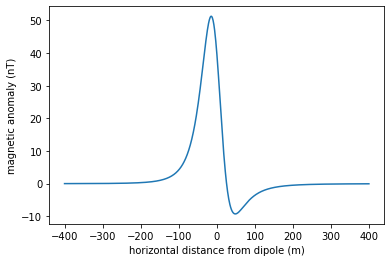

In [3]:
#test out the magnetic_sphere function and verify
# its worksing ok by completely specifying mdoel parameters
depth = 55 # m
radius = 10 # 
mag_inc = 60 #degrees
mag_dec = 0 #degrees
mag_intensity = 1 # Amp/m
earth_inc = 60 #degrees
earth_dec = 0 #degrees

y = 0 #profile line directly over dipole

x = np.arange(-400,400,1) #meters N and S of dipole
mag_model = magnetized_sphere(x, y, depth, radius, mag_inc, mag_dec, mag_intensity, earth_inc, earth_dec)

plt.plot(x,mag_model)
plt.ylabel("magnetic anomaly (nT)")
plt.xlabel("horizontal distance from dipole (m)")
plt.show()

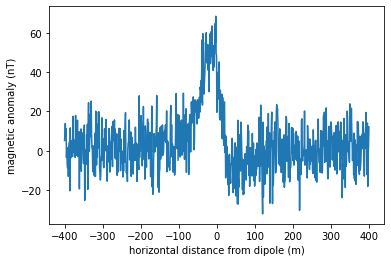

In [4]:
# now create a simulated set of observations
obs_mag = np.random.normal(magnetized_sphere(x, y, depth, radius, mag_inc, 
                                             mag_dec, mag_intensity, 
                                             earth_inc, earth_dec),
                           10) # 10 is the standard deviation of the observational uncertainty

plt.plot(x,obs_mag)
plt.ylabel("magnetic anomaly (nT)")
plt.xlabel("horizontal distance from dipole (m)")
plt.show()

In [5]:
# fit the noisy function with the magnetized sphere model
# using golden search to estimate the depth of the dipole

def sse(depth, obs_mag, x, y, radius, mag_inc, mag_dec, mag_intensity, earth_inc, earth_dec):
    # what function will be minimized?
    # sse = sum of the squared errors between the observed and calculated anomalies
    # notice depth is passed to magnetized sphere, even though this variable is estimated by "golden"
    calc = magnetized_sphere(x, y, depth, radius, mag_inc, mag_dec, mag_intensity, earth_inc, earth_dec)
    sse = sum(obs_mag-calc)**2
    return sse

# all the arguments that are passed to sse (and magnetized sphere) EXCEPT
# for depth, which is the variable we are estimating.
# the arguments are passed as a tuple (,)
mytuple = (obs_mag, x, y, radius, mag_inc, mag_dec, mag_intensity, earth_inc, earth_dec)

# depth is estimated using golden search
# in this case, use brackets because the depth should not be negative.
# the brackets should be such that you are sure the estimated value is 
# between a and b, of (a,b,c)
depth = opt.golden(sse, args=(mytuple), brack=(1,500,1000))
print("estimated depth = ",depth, "m")

estimated depth =  48.87978030512832 m


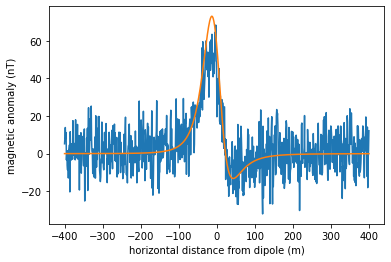

In [6]:
#visually assess the model fit (do you believe the cost function?)
calc_mag = magnetized_sphere(x, y, depth, radius, mag_inc, 
                                             mag_dec, mag_intensity, 
                                             earth_inc, earth_dec)

plt.plot(x,obs_mag)
plt.plot(x,calc_mag)
plt.ylabel("magnetic anomaly (nT)")
plt.xlabel("horizontal distance from dipole (m)")
plt.show()

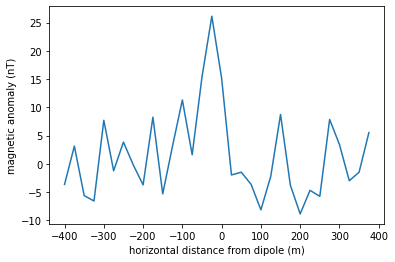

In [24]:
# Now consider a case with relatively few, noisy observations
x = np.arange(-400,400,25)
# now create a simulated set of observations
obs_mag = np.random.normal(magnetized_sphere(x, y, depth, radius, mag_inc, 
                                             mag_dec, mag_intensity, 
                                             earth_inc, earth_dec),
                           5) # 5 is the standard deviation of the observational uncertainty

plt.plot(x,obs_mag)
plt.ylabel("magnetic anomaly (nT)")
plt.xlabel("horizontal distance from dipole (m)")
plt.show()

In [25]:
# fit the noisy function with few observations 
# with the magnetized sphere model
# using golden search to estimate the depth of the dipole

def sse(depth, obs_mag, x, y, radius, mag_inc, mag_dec, mag_intensity, earth_inc, earth_dec):
    # what function will be minimized?
    # sse = sum of the squared errors between the observed and calculated anomalies
    # notice depth is passed to magnetized sphere, even though this variable is estimated by "golden"
    calc = magnetized_sphere(x, y, depth, radius, mag_inc, mag_dec, mag_intensity, earth_inc, earth_dec)
    sse = sum(obs_mag-calc)**2
    return sse

# all the arguments that are passed to sse (and magnetized sphere) EXCEPT
# for depth, which is the variable we are estimating.
# the arguments are passed as a tuple (,)
mytuple = (obs_mag, x, y, radius, mag_inc, mag_dec, mag_intensity, earth_inc, earth_dec)

# depth is estimated using golden search
# in this case, use brackets because the depth should not be negative.
# the brackets should be such that you are sure the estimated value is 
# between a and b, of (a,b,c)
depth = opt.golden(sse, args=(mytuple), brack=(10,100,1000))
print("estimated depth = ",depth, "m")

estimated depth =  79.63411108395519 m


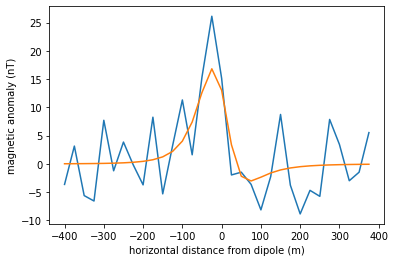

In [26]:
#visually assess the model fit (do you believe the cost function?)
calc_mag = magnetized_sphere(x, y, depth, radius, mag_inc, 
                                             mag_dec, mag_intensity, 
                                             earth_inc, earth_dec)

plt.plot(x,obs_mag)
plt.plot(x,calc_mag)
plt.ylabel("magnetic anomaly (nT)")
plt.xlabel("horizontal distance from dipole (m)")
plt.show()

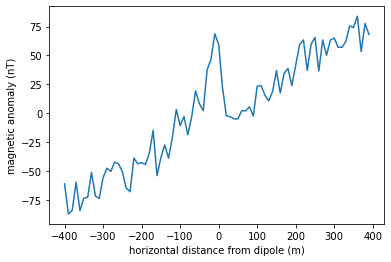

In [20]:
# Now consider a case with relatively few, noisy observations that have a trend that is not modeled
x = np.arange(-400,400,10)
depth = 55
# now create a simulated set of observations
obs_mag = np.random.normal(magnetized_sphere(x, y, depth, radius, mag_inc, 
                                             mag_dec, mag_intensity, 
                                             earth_inc, earth_dec),
                           10) + x/5 # 10 is the standard deviation of the observational uncertainty
                                     # a linear trend is added

plt.plot(x,obs_mag)
plt.ylabel("magnetic anomaly (nT)")
plt.xlabel("horizontal distance from dipole (m)")
plt.show()

In [21]:
# fit the noisy function with few observations 
# with the magnetized sphere model
# using golden search to estimate the depth of the dipole

def sse(depth, obs_mag, x, y, radius, mag_inc, mag_dec, mag_intensity, earth_inc, earth_dec):
    # what function will be minimized?
    # sse = sum of the squared errors between the observed and calculated anomalies
    # notice depth is passed to magnetized sphere, even though this variable is estimated by "golden"
    calc = magnetized_sphere(x, y, depth, radius, mag_inc, mag_dec, mag_intensity, earth_inc, earth_dec)
    sse = sum(obs_mag-calc)**2
    return sse

# all the arguments that are passed to sse (and magnetized sphere) EXCEPT
# for depth, which is the variable we are estimating.
# the arguments are passed as a tuple (,)
mytuple = (obs_mag, x, y, radius, mag_inc, mag_dec, mag_intensity, earth_inc, earth_dec)

# depth is estimated using golden search
# in this case, use brackets because the depth should not be negative.
# the brackets should be such that you are sure the estimated value is 
# between a and b, of (a,b,c)
depth = opt.golden(sse, args=(mytuple), brack=(10,900,1000))
print("estimated depth = ",depth, "m")

estimated depth =  76.07886969386303 m
